In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib


C:\Users\abcetin\AppData\Local\Temp\ipykernel_35184\2316942754.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# --- 1. Veri Yükleme ve Hazırlık ---
print("--- Adım 1: Veri Yükleniyor ve Hazırlanıyor ---")
file_path = 'Sevkiyat _örneklem.xlsx' 

try:
    df = pd.read_excel(file_path)
    
except FileNotFoundError:
    print(f"HATA: '{file_path}' dosyası bulunamadı.")
    exit()

target = 'Yükleme Süresi (dk)'
time_column = 'Yürür.yük.bşl.saati'
df.dropna(subset=[target, time_column], inplace=True)




--- Adım 1: Veri Yükleniyor ve Hazırlanıyor ---


In [3]:

# --- 2.Feature Engineering ---
print("\n--- Adım 2: Yeni Özellikler Oluşturuluyor ---")
df['Yükleme Başlangıç Saati'] = pd.to_datetime(df[time_column], format='%H:%M:%S', errors='coerce').dt.hour
df.dropna(subset=['Yükleme Başlangıç Saati'], inplace=True)
df['Yükleme Başlangıç Saati'] = df['Yükleme Başlangıç Saati'].astype(int)
print("'Yükleme Başlangıç Saati' özelliği oluşturuldu.")



--- Adım 2: Yeni Özellikler Oluşturuluyor ---
'Yükleme Başlangıç Saati' özelliği oluşturuldu.


In [4]:
# --- 3. Aykırı Değerleri Filtreleme (En Önemli Adım) ---
print("\n--- Adım 3: Aykırı Değerler Filtreleniyor ---")
outlier_threshold = df[target].quantile(0.99)
df_filtered = df[df[target] <= outlier_threshold].copy()
print(f"Verinin %99'luk dilimi kullanılıyor (süre <= {outlier_threshold:.2f} dakika).")



--- Adım 3: Aykırı Değerler Filtreleniyor ---
Verinin %99'luk dilimi kullanılıyor (süre <= 180.12 dakika).



--- Adım 4: Kapsamlı Analiz Grafikleri Oluşturuluyor ---
Grafik kaydedildi: grafik_1_hedef_dagilimi.png
Grafik kaydedildi: grafik_2_kaynak_adresler.png
Grafik kaydedildi: grafik_3_sevkiyat_turu.png
Grafik kaydedildi: grafik_4_haziredim_yeri.png


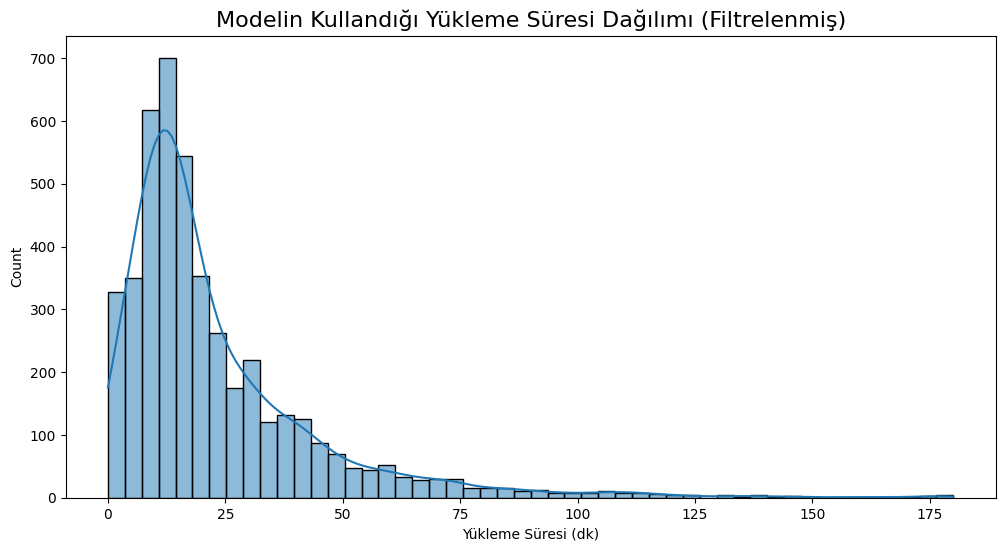

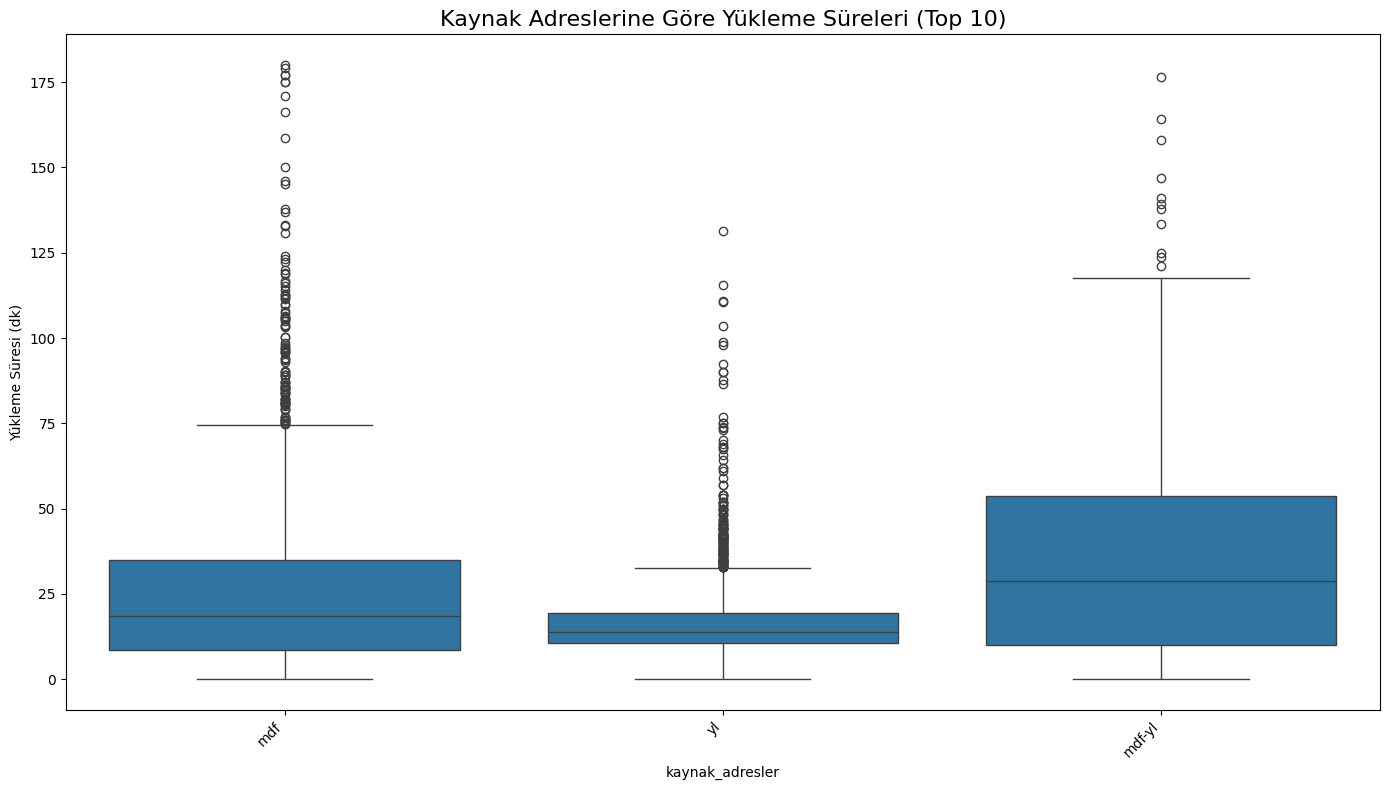

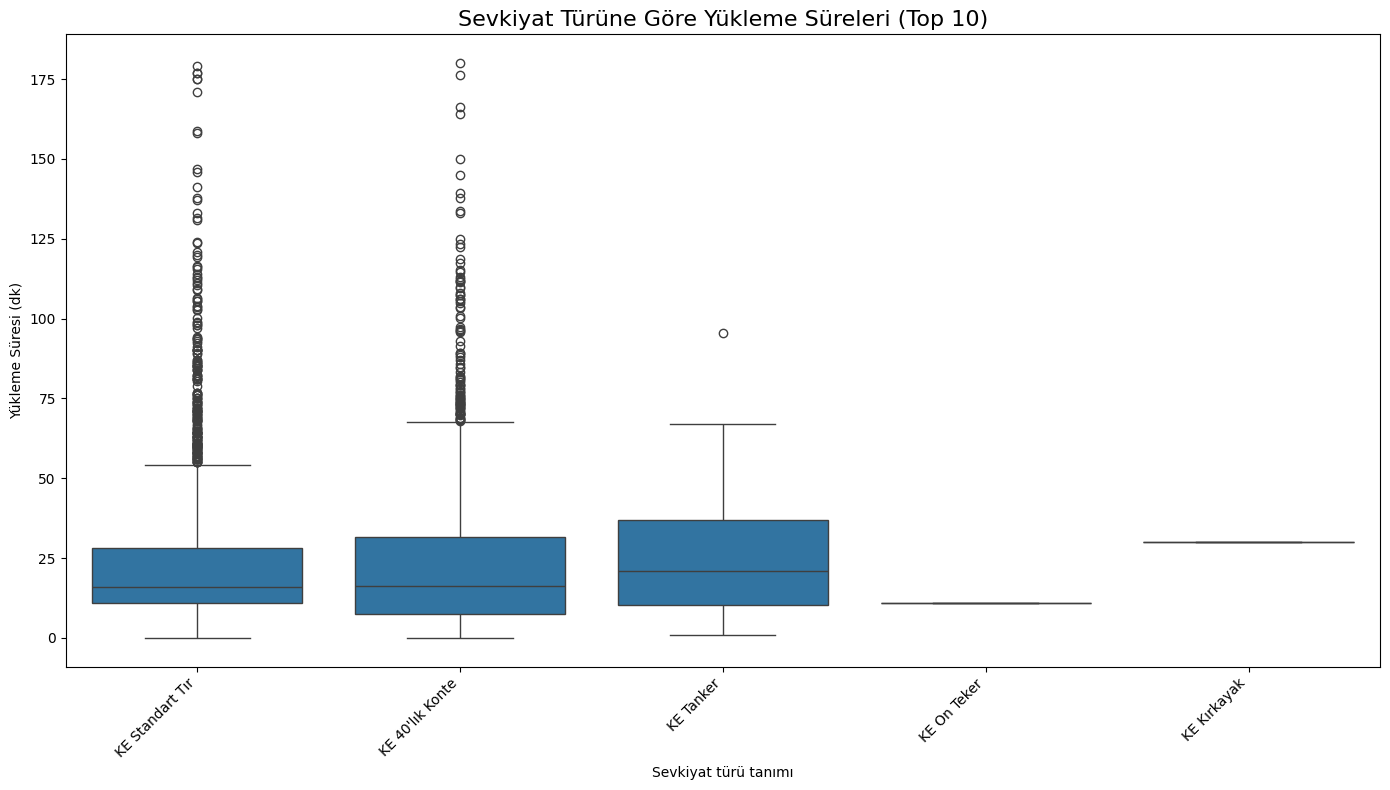

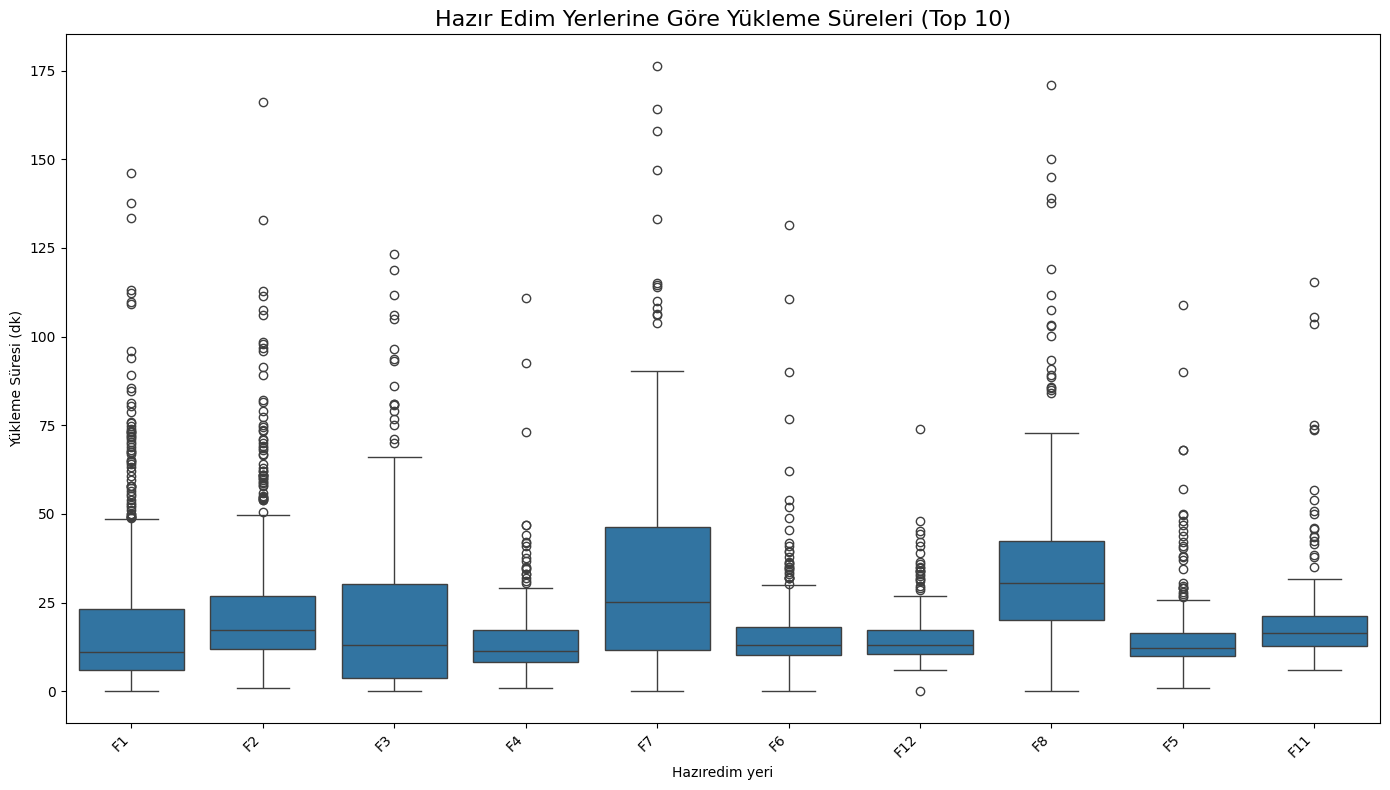

In [5]:

# --- 4. KAPSAMLI VERİ ANALİZİ VE GÖRSELLEŞTİRME ---
print("\n--- Adım 4: Kapsamlı Analiz Grafikleri Oluşturuluyor ---")
plt.figure(figsize=(12, 6))
sns.histplot(df_filtered[target], bins=50, kde=True)
plt.title('Modelin Kullandığı Yükleme Süresi Dağılımı (Filtrelenmiş)', fontsize=16)
plt.savefig('grafik_1_hedef_dagilimi.png')
print("Grafik kaydedildi: grafik_1_hedef_dagilimi.png")
if 'kaynak_adresler' in df_filtered.columns:
    plt.figure(figsize=(14, 8))
    top_categories = df_filtered['kaynak_adresler'].value_counts().nlargest(10).index
    sns.boxplot(x='kaynak_adresler', y=target, data=df_filtered[df_filtered['kaynak_adresler'].isin(top_categories)], order = top_categories)
    plt.title('Kaynak Adreslerine Göre Yükleme Süreleri (Top 10)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('grafik_2_kaynak_adresler.png')
    print("Grafik kaydedildi: grafik_2_kaynak_adresler.png")

if 'Sevkiyat türü tanımı' in df_filtered.columns:
    plt.figure(figsize=(14, 8))
    top_categories = df_filtered['Sevkiyat türü tanımı'].value_counts().nlargest(10).index
    sns.boxplot(x='Sevkiyat türü tanımı', y=target, data=df_filtered[df_filtered['Sevkiyat türü tanımı'].isin(top_categories)], order = top_categories)
    plt.title('Sevkiyat Türüne Göre Yükleme Süreleri (Top 10)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('grafik_3_sevkiyat_turu.png')
    print("Grafik kaydedildi: grafik_3_sevkiyat_turu.png")

if 'Hazıredim yeri' in df_filtered.columns:
    plt.figure(figsize=(14, 8))
    top_categories = df_filtered['Hazıredim yeri'].value_counts().nlargest(10).index
    sns.boxplot(x='Hazıredim yeri', y=target, data=df_filtered[df_filtered['Hazıredim yeri'].isin(top_categories)], order = top_categories)
    plt.title('Hazır Edim Yerlerine Göre Yükleme Süreleri (Top 10)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('grafik_4_haziredim_yeri.png')
    print("Grafik kaydedildi: grafik_4_haziredim_yeri.png")


In [6]:
# --- 5. MODEL KURULUMU, EĞİTİMİ VE DEĞERLENDİRMESİ ---

columns_to_drop = [
    'Yükl.bitiş sa/yürür.', 'Yürür.yük.bşl.saati', 'Yürür.yükl.bşl.', 'Yürür.yükl.sonu',
    'Nkl.aracı tanıtıcısı'
]
df_filtered = df_filtered.drop(columns=[col for col in columns_to_drop if col in df_filtered.columns], axis=1)

X = df_filtered.drop(target, axis=1)
y = df_filtered[target]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

final_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("\n--- FİNAL MODEL DEĞERLENDİRME SONUÇLARI ---")
print(f'Ortalama Mutlak Hata (MAE): {mean_absolute_error(y_test, y_pred):.2f} dakika')
print(f'R-Kare (R2) Skoru: {r2_score(y_test, y_pred):.2f}')



--- FİNAL MODEL DEĞERLENDİRME SONUÇLARI ---
Ortalama Mutlak Hata (MAE): 12.64 dakika
R-Kare (R2) Skoru: 0.17


In [7]:
# --- 6. MODEL YORUMLAMA: ÖZELLİK ÖNEMLERİ ---
print("\n--- Adım 6: Modelin Kararları Yorumlanıyor ---")
ohe_feature_names = final_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)
importances = final_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Özellik': all_feature_names, 'Önem': importances})
feature_importance_df = feature_importance_df.sort_values(by='Önem', ascending=False)

print("\nModelin En Önemli Gördüğü 20 Özellik:")
print(feature_importance_df.head(20))



--- Adım 6: Modelin Kararları Yorumlanıyor ---

Modelin En Önemli Gördüğü 20 Özellik:
                      Özellik      Önem
2                     Hacim_x  0.153718
0                   HK kantar  0.098264
3                   TK kantar  0.089972
5              Ambalaj sayısı  0.087291
7     Yükleme Başlangıç Saati  0.069150
6    benzersiz_malzeme_sayisi  0.066486
1               Net ağırlık_x  0.057899
4                         Gün  0.032882
337         Hazıredim yeri_F3  0.022239
339        Hazıredim yeri_F40  0.014036
329        Hazıredim yeri_F14  0.013353
332         Hazıredim yeri_F2  0.012361
346    kaynak_adresler_mdf-yl  0.010262
224    Sipariş veren_21007745  0.009903
148                 Vardiya_A  0.008277
342         Hazıredim yeri_F7  0.008117
10               Yaratan_x_A3  0.007493
9                Yaratan_x_A2  0.007388
149                 Vardiya_B  0.006837
324         Hazıredim yeri_F1  0.005487


In [ ]:
# --- 7. MODELİN KAYDEDİLMESİ ---
print("\n--- Adım 7: Final Model Kaydediliyor ---")
joblib.dump(final_model, 'sevkiyat_suresi_modeli.joblib')
print("\nEğitilmiş model 'sevkiyat_suresi_modeli.joblib' dosyasına başarıyla kaydedildi.")


--- Adım 7: Final Model Kaydediliyor ---

Eğitilmiş model 'sevkiyat_suresi_modeli.joblib' dosyasına başarıyla kaydedildi.
